In [ ]:
!pip install -U bitsandbytes
!pip install huggingface_hub



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
!pip install pymupdf pytesseract pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 83.6 MB/s eta 0:00:00


In [ ]:
!pip install torch transformers
!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
!pip install accelerate
!pip install evaluate
!pip install rouge
!pip install bert_score


In [ ]:
import os
import fitz  # PyMuPDF
import pytesseract
from PIL import Image
import torch
from transformers import LEDTokenizer, LEDForConditionalGeneration, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from evaluate import load as load_metric
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import login

login(token="")


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, LEDTokenizer, LEDForConditionalGeneration, BitsAndBytesConfig
from sklearn.metrics import precision_score, recall_score, f1_score
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score
import fitz
import os
import json
import torch

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    doc.close()
    return text if text.strip() else None

def preprocess_text(text):
    return " ".join(text.split())

def load_led_model(model_name="allenai/led-base-16384"):
    tokenizer = LEDTokenizer.from_pretrained(model_name)
    model = LEDForConditionalGeneration.from_pretrained(model_name)
    model.to("cuda")
    return tokenizer, model

def summarize_text(text, tokenizer, model):

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=4096).to("cuda")
    attention_mask = inputs['attention_mask']  # Generate attention mask

    summary_ids = model.generate(
        inputs.input_ids,
        attention_mask=attention_mask,
        pad_token_id=tokenizer.pad_token_id,  # Proper padding
        max_length=512
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

from transformers import AutoTokenizer, AutoModelForCausalLM

def load_quantized_llama(model_name="meta-llama/Llama-3.1-8B-Instruct"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Define your quantization configuration
    quantization_config = BitsAndBytesConfig(
        load_in_8bit=True,
        llm_int8_enable_fp32_cpu_offload=True
    )

    max_memory = {i: "13GB" for i in range(torch.cuda.device_count())}
    max_memory["cpu"] = "30GB"

    # Load the model with the quantization config
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype=torch.float16,
        quantization_config=quantization_config,
        max_memory=max_memory
    )

    return tokenizer, model

def interpret_summary(summary_text, tokenizer, model):
    # Ensure pad_token is defined
    if tokenizer.pad_token is None:
        # Option 1: Set pad_token to eos_token if available
        if tokenizer.eos_token:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            # Option 2: Add a new pad token
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    prompt = f"""
You are an AI trained in Indian legal document summarization.
Your task is to analyze the following case summary and provide a **clear, structured explanation** for a layperson with little legal knowledge.

Ensure that the summary is **simple, jargon-free**, and directly useful for someone unfamiliar with legal terms.
Include any relevant **Indian laws, sections, or precedents** where necessary.

### **Structured Summary:**

1. **Background of the Case**
   - What is the case about?
   - Who are the parties involved?
   - When and where did this case take place?

2. **Key Legal Issues**
   - What are the main legal questions being addressed?
   - Are there specific sections of Indian law that apply?

3. **Arguments from Both Sides**
   - **Plaintiff’s Claims:** What did the complainant argue?
   - **Defendant’s Defense:** How did the accused/respondent defend themselves?

4. **Court’s Decision & Reasoning**
   - What was the final judgment?
   - What reasons did the court give?

5. **Impact & Lessons for the Public**
   - How does this case affect future legal cases?
   - What should a common person learn from this judgment?

6. **Important Legal Takeaways (In Simple Terms)**
   - If this happens to you, what should you do?
   - Which laws protect you in a similar situation?

### **Case Summary:**
{summary_text}
    """

    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")
    output_ids = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=512,
        temperature=0.6,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id
    )
    structured_summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return structured_summary



def evaluate_summary(predicted_summary, reference_summary):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(predicted_summary, reference_summary, avg=True)

    # Use SmoothingFunction for better BLEU score calculation with shorter sentences
    smooth = SmoothingFunction().method1
    bleu_score = sentence_bleu([reference_summary.split()], predicted_summary.split(), smoothing_function=smooth)

    P, R, F1 = bert_score([predicted_summary], [reference_summary], lang="en")
    bert_score_f1 = F1.mean().item()

    return {
        "ROUGE": rouge_scores,
        "BLEU": bleu_score,
        "BERTScore": bert_score_f1
    }

def process_legal_document(pdf_path, led_model, led_tokenizer, llama_model, llama_tokenizer):
    raw_text = extract_text_from_pdf(pdf_path)
    processed_text = preprocess_text(raw_text)

    summary = summarize_text(processed_text, led_tokenizer, led_model)
    structured_summary = interpret_summary(summary, llama_tokenizer, llama_model)
    return structured_summary

def main(test_folder, reference_folder, output_file):
    led_tokenizer, led_model = load_led_model()
    llama_tokenizer, llama_model = load_quantized_llama()

    results = {}
    for pdf_file in os.listdir(test_folder):
        if not pdf_file.endswith(".pdf"):
            continue

        pdf_path = os.path.join(test_folder, pdf_file)
        reference_path = os.path.join(reference_folder, pdf_file.replace(".pdf", ".txt"))

        if not os.path.exists(reference_path):
            print(f"Reference summary not found for {pdf_file}")
            continue

        with open(reference_path, "r") as ref_file:
            reference_summary = ref_file.read().strip()

        try:
            structured_summary = process_legal_document(pdf_path, led_model, led_tokenizer, llama_model, llama_tokenizer)
            print(f"Processed: {pdf_file}")  # Log processed files
        except Exception as e:
            print(f"Error processing {pdf_file}: {e}")
            continue

        scores = evaluate_summary(structured_summary, reference_summary)
        print(f"Scores for {pdf_file}: {scores}")  # Log evaluation scores
        results[pdf_file] = scores

    with open(output_file, "w") as out_file:
        json.dump(results, out_file, indent=4)
    print(f"Results saved to {output_file}")


if __name__ == "__main__":
    test_folder = "/content/drive/MyDrive/Testing Files"
    reference_folder = "/content/drive/MyDrive/Reference Summary"
    output_file = "/content/drive/MyDrive/Evaluation_Scores.json"

    main(test_folder, reference_folder, output_file)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Processed: Landownership - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Landownership - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.08583690987124463, 'p': 0.12738853503184713, 'f': 0.10256409775397789}, 'rouge-2': {'r': 0.008108108108108109, 'p': 0.013452914798206279, 'f': 0.010118039152111239}, 'rouge-l': {'r': 0.08583690987124463, 'p': 0.12738853503184713, 'f': 0.10256409775397789}}, 'BLEU': 0.0017371567492538854, 'BERTScore': 0.7797759771347046}
Processed: Breachofcontract - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Breachofcontract - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.19865319865319866, 'p': 0.19155844155844157, 'f': 0.19504131731570262}, 'rouge-2': {'r': 0.034334763948497854, 'p': 0.03088803088803089, 'f': 0.032520320217216056}, 'rouge-l': {'r': 0.19528619528619529, 'p': 0.18831168831168832, 'f': 0.19173553219173567}}, 'BLEU': 0.005658248118511202, 'BERTScore': 0.7817655205726624}
Processed: Defamation - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Defamation - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.24444444444444444, 'p': 0.2323943661971831, 'f': 0.2382671430176336}, 'rouge-2': {'r': 0.09130434782608696, 'p': 0.08936170212765958, 'f': 0.09032257564573969}, 'rouge-l': {'r': 0.22592592592592592, 'p': 0.2147887323943662, 'f': 0.2202166015013881}}, 'BLEU': 0.08273114699268884, 'BERTScore': 0.7808128595352173}
Processed: Compenstation - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Compenstation - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.17446808510638298, 'p': 0.22404371584699453, 'f': 0.19617224388120708}, 'rouge-2': {'r': 0.03816793893129771, 'p': 0.051194539249146756, 'f': 0.04373177353190478}, 'rouge-l': {'r': 0.1702127659574468, 'p': 0.2185792349726776, 'f': 0.19138755488599174}}, 'BLEU': 0.006009775883595632, 'BERTScore': 0.7953988313674927}
Processed: Disputes - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Disputes - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.17475728155339806, 'p': 0.14634146341463414, 'f': 0.15929203043738757}, 'rouge-2': {'r': 0.024539877300613498, 'p': 0.019417475728155338, 'f': 0.0216802118700667}, 'rouge-l': {'r': 0.16019417475728157, 'p': 0.13414634146341464, 'f': 0.14601769415420177}}, 'BLEU': 0.007329570466758679, 'BERTScore': 0.7812858819961548}
Processed: Divorce - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Divorce - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.40160642570281124, 'p': 0.27548209366391185, 'f': 0.32679738079440607}, 'rouge-2': {'r': 0.14492753623188406, 'p': 0.08995502248875563, 'f': 0.11100832089830164}, 'rouge-l': {'r': 0.37751004016064255, 'p': 0.25895316804407714, 'f': 0.3071895376571511}}, 'BLEU': 0.06339304790116428, 'BERTScore': 0.7898261547088623}
Processed: Alimony - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Alimony - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.16988416988416988, 'p': 0.16236162361623616, 'f': 0.1660377308516199}, 'rouge-2': {'r': 0.043373493975903614, 'p': 0.0391304347826087, 'f': 0.04114285215608224}, 'rouge-l': {'r': 0.15444015444015444, 'p': 0.14760147601476015, 'f': 0.15094339122897843}}, 'BLEU': 0.00635539893069459, 'BERTScore': 0.7748162150382996}
Processed: Childcustody - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Childcustody - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.1857707509881423, 'p': 0.21076233183856502, 'f': 0.1974789866164997}, 'rouge-2': {'r': 0.07515657620041753, 'p': 0.10495626822157435, 'f': 0.08759123601278139}, 'rouge-l': {'r': 0.1541501976284585, 'p': 0.17488789237668162, 'f': 0.16386554123834843}}, 'BLEU': 0.051828167740918515, 'BERTScore': 0.7765109539031982}
Processed: Murder - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Murder - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.16044776119402984, 'p': 0.16731517509727625, 'f': 0.16380951881171896}, 'rouge-2': {'r': 0.037037037037037035, 'p': 0.04116222760290557, 'f': 0.03899082070198805}, 'rouge-l': {'r': 0.15298507462686567, 'p': 0.15953307392996108, 'f': 0.15619047119267135}}, 'BLEU': 0.01509541125418986, 'BERTScore': 0.794762134552002}
Processed: Assault - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Assault - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.23018867924528302, 'p': 0.20677966101694914, 'f': 0.21785713787149244}, 'rouge-2': {'r': 0.10256410256410256, 'p': 0.09195402298850575, 'f': 0.09696969198457325}, 'rouge-l': {'r': 0.21509433962264152, 'p': 0.19322033898305085, 'f': 0.20357142358577818}}, 'BLEU': 0.05978214211398542, 'BERTScore': 0.7946639657020569}
Processed: Kidnapping - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Kidnapping - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.18118466898954705, 'p': 0.20155038759689922, 'f': 0.19082568308755168}, 'rouge-2': {'r': 0.044573643410852716, 'p': 0.053488372093023255, 'f': 0.04862578785316215}, 'rouge-l': {'r': 0.1672473867595819, 'p': 0.18604651162790697, 'f': 0.1761467840049829}}, 'BLEU': 0.0221330937333173, 'BERTScore': 0.7690796852111816}
Processed: Robbery - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Robbery - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.24584717607973422, 'p': 0.22981366459627328, 'f': 0.23756018762205358}, 'rouge-2': {'r': 0.07321772639691715, 'p': 0.06654991243432574, 'f': 0.06972476565358171}, 'rouge-l': {'r': 0.22259136212624583, 'p': 0.2080745341614907, 'f': 0.21508827750969403}}, 'BLEU': 0.038450818918684654, 'BERTScore': 0.7814214825630188}
Processed: Cheating - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Cheating - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.4057377049180328, 'p': 0.3113207547169811, 'f': 0.3523131623464749}, 'rouge-2': {'r': 0.19406392694063926, 'p': 0.15370705244122965, 'f': 0.17154389012283114}, 'rouge-l': {'r': 0.38114754098360654, 'p': 0.29245283018867924, 'f': 0.3309608491792151}}, 'BLEU': 0.10608351139178115, 'BERTScore': 0.7960895299911499}
Processed: Forgery - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Forgery - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.3568281938325991, 'p': 0.23684210526315788, 'f': 0.28471001277893265}, 'rouge-2': {'r': 0.13917525773195877, 'p': 0.08823529411764706, 'f': 0.1079999952508802}, 'rouge-l': {'r': 0.3436123348017621, 'p': 0.22807017543859648, 'f': 0.2741651973132033}}, 'BLEU': 0.06313495204398369, 'BERTScore': 0.7944060564041138}
Processed: MoneyLaundering - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for MoneyLaundering - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.30569948186528495, 'p': 0.184375, 'f': 0.23001948848382608}, 'rouge-2': {'r': 0.10736196319018405, 'p': 0.0625, 'f': 0.07900676735779574}, 'rouge-l': {'r': 0.29015544041450775, 'p': 0.175, 'f': 0.21832358205107752}}, 'BLEU': 0.047888543013534624, 'BERTScore': 0.7987910509109497}
Processed: Crime - 1.pdf


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Scores for Crime - 1.pdf: {'ROUGE': {'rouge-1': {'r': 0.22815533980582525, 'p': 0.188, 'f': 0.20614034592374592}, 'rouge-2': {'r': 0.08115942028985507, 'p': 0.07368421052631578, 'f': 0.07724137432199793}, 'rouge-l': {'r': 0.21359223300970873, 'p': 0.176, 'f': 0.1929824511869038}}, 'BLEU': 0.027547234024052514, 'BERTScore': 0.8000203371047974}
Results saved to /content/drive/MyDrive/Evaluation_Scores.json


In [ ]:
import pandas as pd

def load_results(file_path):
    with open(file_path, "r") as f:
        results = json.load(f)
    return results

def prepare_dataframe(results):
    data = []
    for doc, scores in results.items():
        data.append({
            "Document": doc,
            "ROUGE-1": scores["ROUGE"]["rouge-1"]["f"],
            "ROUGE-2": scores["ROUGE"]["rouge-2"]["f"],
            "ROUGE-L": scores["ROUGE"]["rouge-l"]["f"],
            "BLEU": scores["BLEU"],
            "BERTScore": scores["BERTScore"]
        })
    return pd.DataFrame(data)

# Load results from JSON file and prepare dataframe
results = load_results("/content/drive/MyDrive/Evaluation_Scores.json")
df = prepare_dataframe(results)


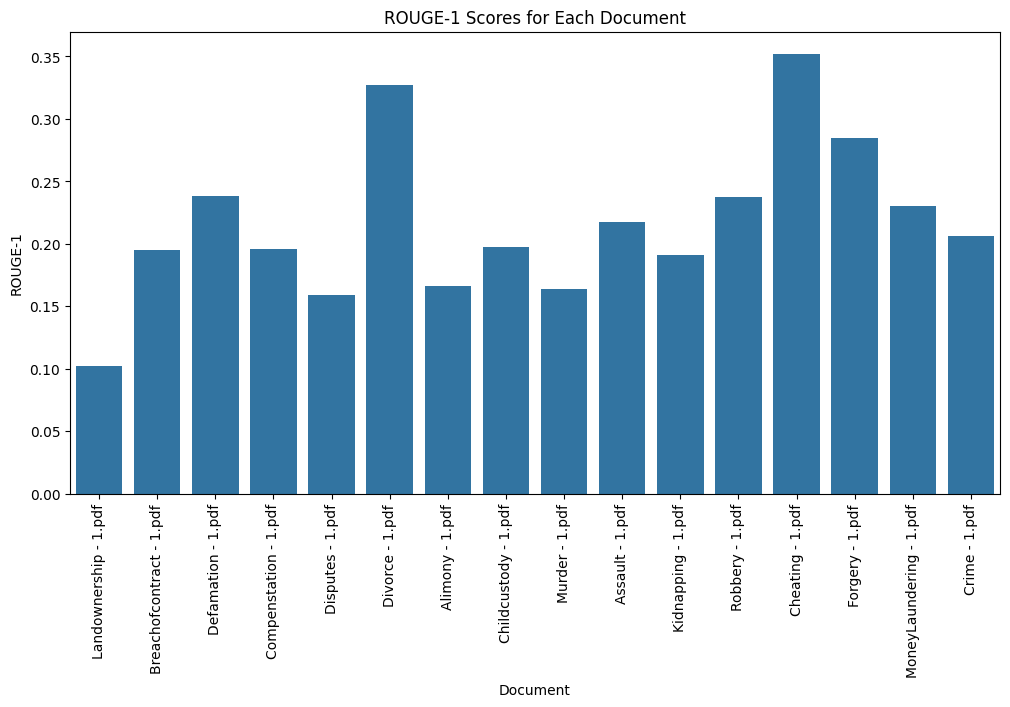

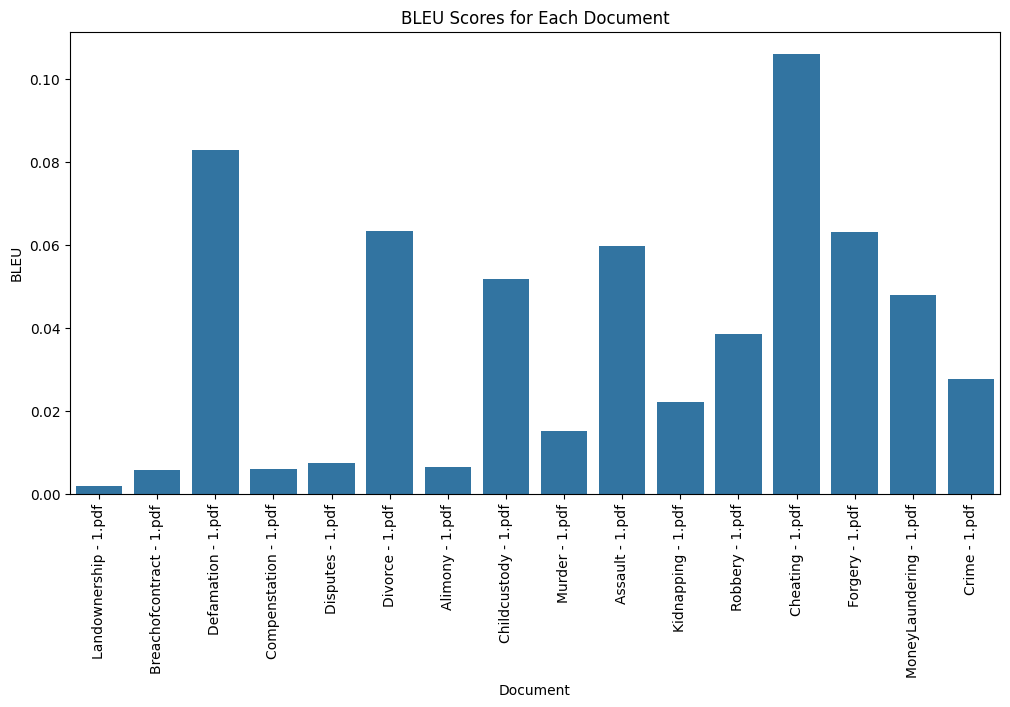

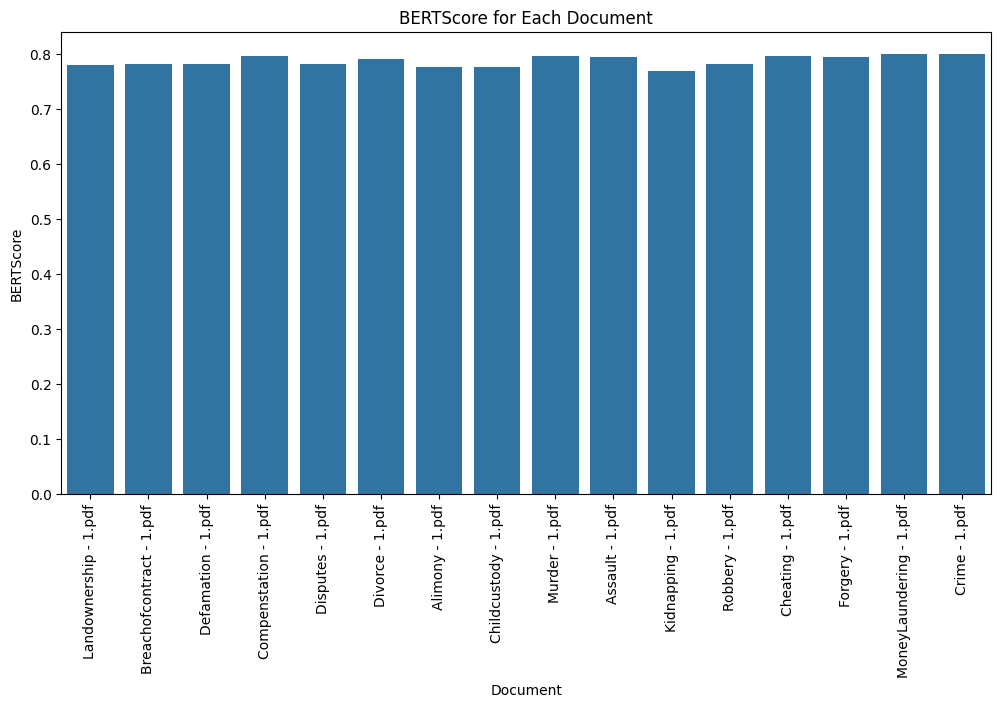

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar_charts(df):
    # ROUGE-1
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Document", y="ROUGE-1", data=df)
    plt.title("ROUGE-1 Scores for Each Document")
    plt.xticks(rotation=90)
    plt.show()

    # BLEU
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Document", y="BLEU", data=df)
    plt.title("BLEU Scores for Each Document")
    plt.xticks(rotation=90)
    plt.show()

    # BERTScore
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Document", y="BERTScore", data=df)
    plt.title("BERTScore for Each Document")
    plt.xticks(rotation=90)
    plt.show()

# Call the function to plot bar charts
plot_bar_charts(df)


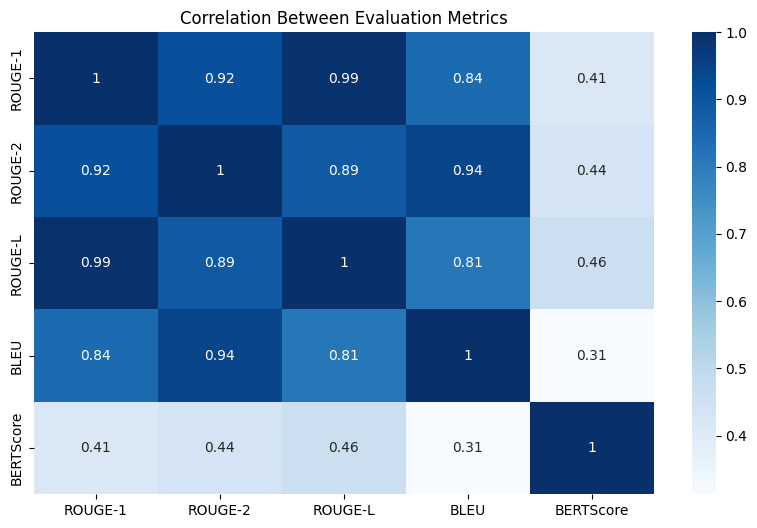

In [ ]:
def plot_heatmap(df):
    # Correlation Heatmap
    plt.figure(figsize=(10, 6))
    corr = df[["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "BERTScore"]].corr()
    sns.heatmap(corr, annot=True, cmap="Blues")
    plt.title("Correlation Between Evaluation Metrics")
    plt.show()

# Call the function to plot heatmap
plot_heatmap(df)


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def plot_interactive_charts(df):
    # Line Plot for Evaluation Scores
    fig = px.line(df, x="Document", y=["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "BERTScore"], title="Evaluation Scores Across Documents")
    fig.show()

    # Bar Plot for BERTScore
    fig2 = px.bar(df, x="Document", y="BERTScore", title="BERTScore for Each Document")
    fig2.show()

    # Heatmap of Evaluation Metrics
    fig3 = go.Figure(data=[go.Heatmap(z=df[["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "BERTScore"]].values,
                                      x=["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "BERTScore"],
                                      y=df["Document"].values,
                                      colorscale='Viridis')])
    fig3.update_layout(title="Heatmap of Evaluation Metrics")
    fig3.show()

# Call the function to plot interactive charts
plot_interactive_charts(df)


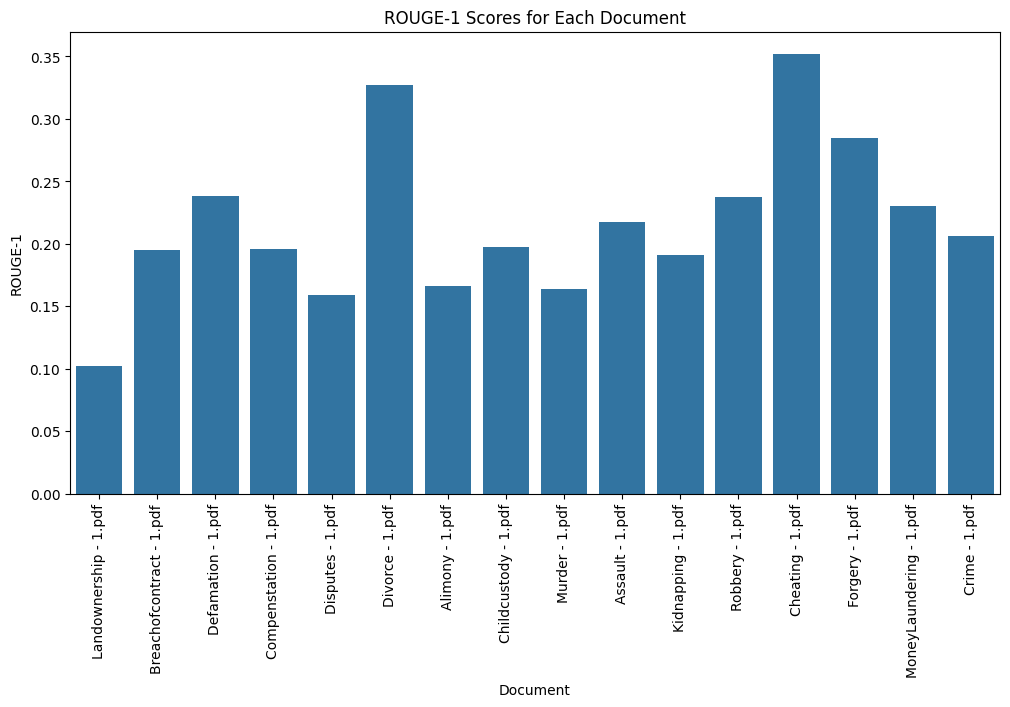

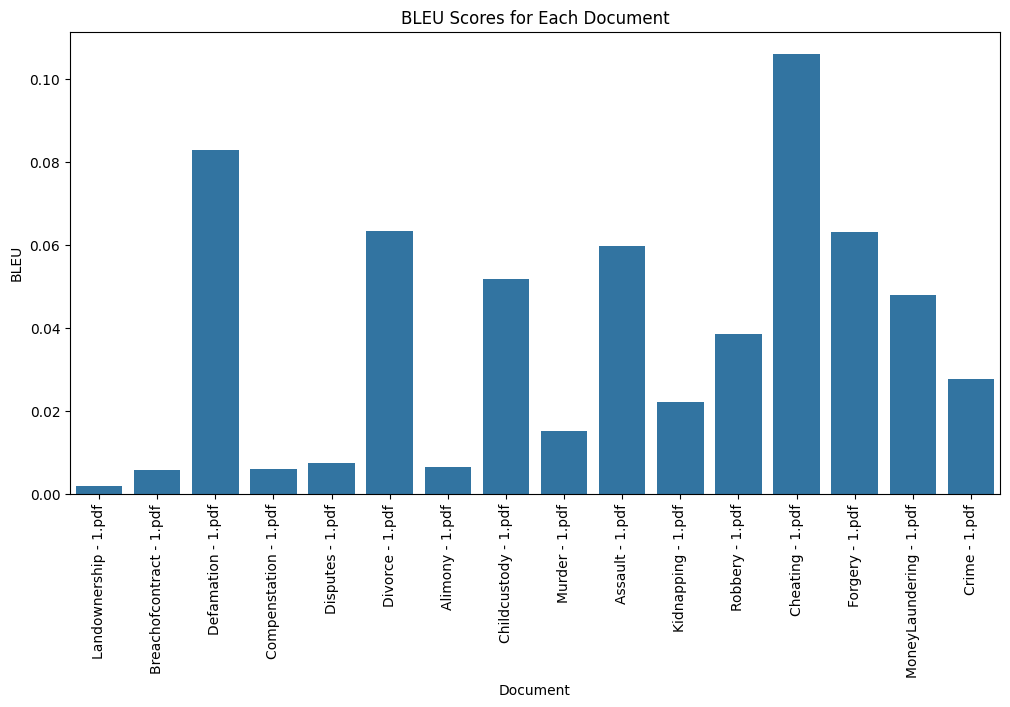

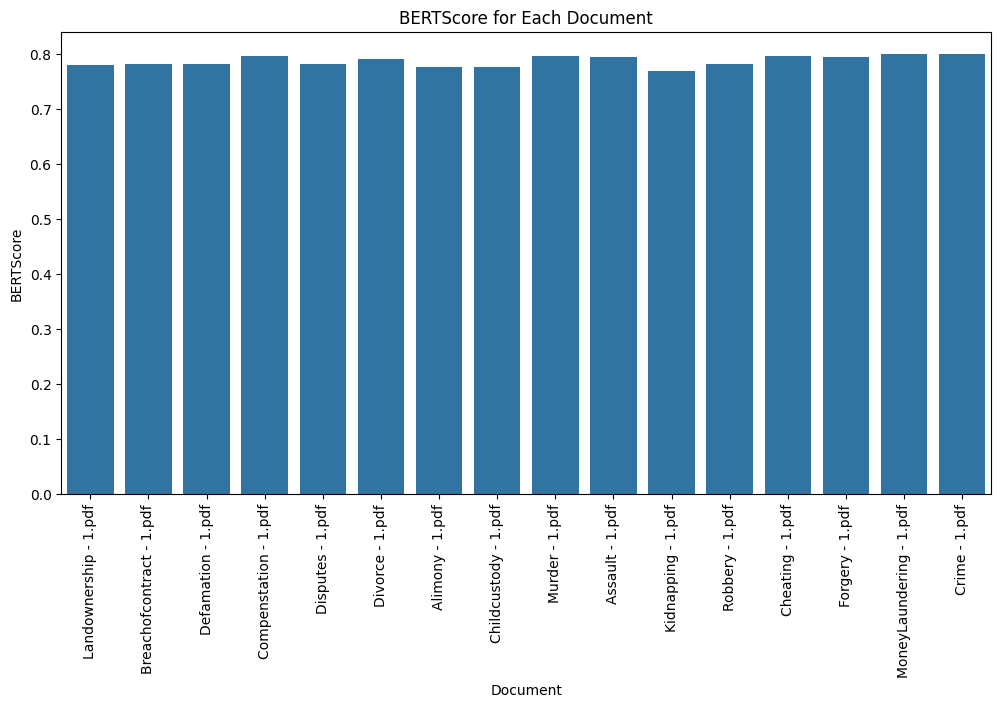

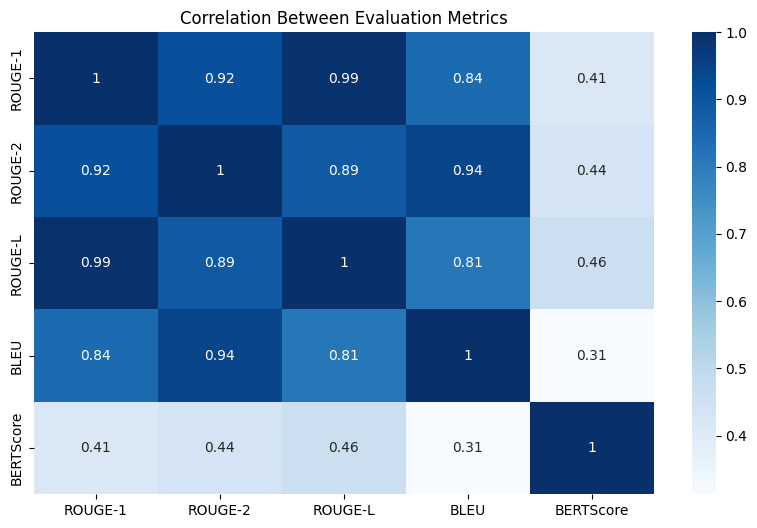

In [ ]:
def main():
    results = load_results("/content/drive/MyDrive/Evaluation_Scores.json")
    df = prepare_dataframe(results)

    plot_bar_charts(df)
    plot_heatmap(df)
    plot_interactive_charts(df)

# Call the main function to execute all visualizations
main()
